In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
from scipy.stats import truncnorm
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall

In [2]:
def generate_customer_features(n):
    np.random.seed(42)
    age = np.clip(np.random.normal(40, 12, n).astype(int), 18, 70)  # Normal distribution, clipped to 18-70
    # Use truncated normal for income to avoid mode at lower bound

    lower, upper = 40000, 180000
    mu, sigma = 75000, 35000
    a, b = (lower - mu) / sigma, (upper - mu) / sigma
    income = truncnorm(a, b, loc=mu, scale=sigma).rvs(n).astype(int)
    marital_status = np.random.choice(['single', 'married', 'divorced'], n, p=[0.5, 0.4, 0.1])
    # Conversion: correlated with income, age, marital status, but target ~8%
    logits = 0.7 * (income > 65000).astype(int) + 0.5 * (age > 40).astype(int) + 0.6 * (marital_status == 'married').astype(int)
    logits = logits + np.random.normal(0, 0.5, n)
    prob = 1 / (1 + np.exp(-logits - 2.2))  # Shift to lower base rate
    conversion = np.random.binomial(1, prob)
    return pd.DataFrame({
        'user_id': np.arange(n),
        'age': age,
        'income': income,
        'marital_status': marital_status,
        'conversion': conversion.astype(int)
    })

def generate_touchpoints(n, max_tp, channels, campaigns):
    touchpoints = []
    for user_id in range(n):
        num_tp = np.random.randint(1, max_tp+1)
        for t in range(num_tp):
            touchpoints.append({
                'user_id': user_id,
                'tp_order': t,
                'channel': np.random.choice(channels),
                'campaign': np.random.choice(campaigns)
            })
    return pd.DataFrame(touchpoints)

In [3]:
# Parameters
data_size = 10000
max_touchpoints = 8
channels = ['Email', 'Paid Search', 'Organic Search', 'Social', 'Display', 'Direct']
campaigns = [
    'Brand Awareness', 'Holiday Promo', 'Retargeting', 'Product Launch', 'Abandoned Cart',
    'Loyalty Program', 'Referral', 'Flash Sale', 'Seasonal', 'Content Marketing'
 ]

customers = generate_customer_features(data_size)
touchpoints = generate_touchpoints(data_size, max_touchpoints, channels, campaigns)
num_channels = len(channels)
num_campaigns = len(campaigns)

# Show the first few rows
display(customers.head())
display(touchpoints.head())

,user_id,age,income,marital_status,conversion
0,0,45,68693,single,1
1,1,38,50860,single,1
2,2,47,47851,divorced,1
3,3,58,50036,married,1
4,4,37,88322,single,1


,user_id,tp_order,channel,campaign
0,0,0,Social,Abandoned Cart
1,0,1,Paid Search,Content Marketing
2,0,2,Email,Referral
3,0,3,Direct,Holiday Promo
4,1,0,Organic Search,Product Launch


In [27]:
conversion_counts = customers.groupby('conversion')['user_id'].count()
conversion_percentages = conversion_counts / customers.shape[0]
result = pd.DataFrame({
	'count': conversion_counts,
	'percentage': conversion_percentages # format as percentage
})
result['percentage'] = result['percentage'].apply(lambda x: f'{x:.2%}')
result

,count,percentage
conversion,,
0,465,4.65%
1,9535,95.35%


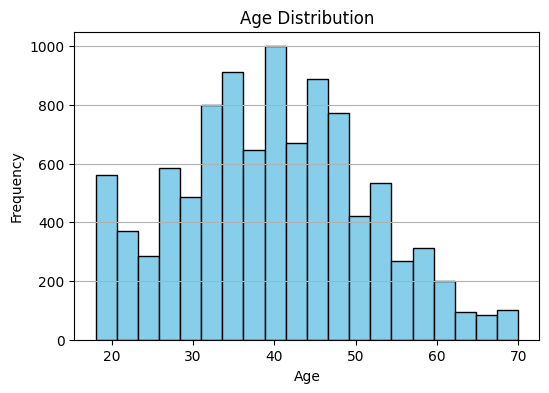

In [5]:
# distribution of age
plt.figure(figsize=(6, 4))
plt.hist(customers['age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

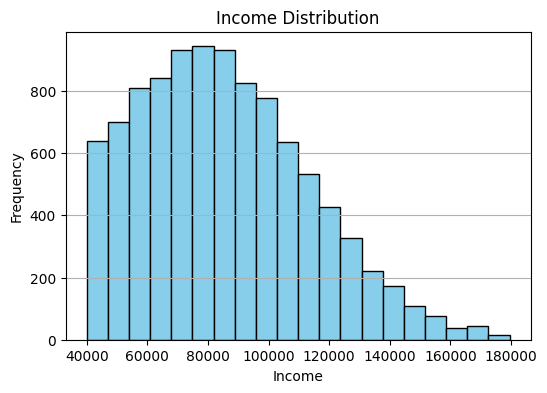

In [6]:
plt.figure(figsize=(6, 4))
plt.hist(customers['income'], bins=20, color='skyblue', edgecolor='black')
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

#### Preprocess data

In [7]:
# Preprocess data for LSTM input
le_marital = LabelEncoder()
customers['marital_status_enc'] = le_marital.fit_transform(customers['marital_status'])

le_channel = LabelEncoder()
touchpoints['channel_enc'] = le_channel.fit_transform(touchpoints['channel'])
le_campaign = LabelEncoder()
touchpoints['campaign_enc'] = le_campaign.fit_transform(touchpoints['campaign'])

# Prepare sequences
X_seq = np.zeros((data_size, max_touchpoints, 2), dtype=int)  # channel, campaign
for user_id, group in touchpoints.groupby('user_id'):
    for i, row in enumerate(group.sort_values('tp_order').itertuples()):
        if i < max_touchpoints:
            X_seq[user_id, i, 0] = row.channel_enc
            X_seq[user_id, i, 1] = row.campaign_enc

# Prepare customer features
scaler = StandardScaler()
X_cust = scaler.fit_transform(customers[['age', 'income', 'marital_status_enc']])
y = customers['conversion'].values

X_channel = X_seq[:, :, 0]
X_campaign = X_seq[:, :, 1]

#### Train Model

In [8]:
# Hyperparameters
lstm_units = 32
batch_size = 64
epochs = 30
embedding_dim = 4

In [9]:
# Model definition
channel_input = Input(shape=(max_touchpoints,), dtype='int32', name='channel_input')
campaign_input = Input(shape=(max_touchpoints,), dtype='int32', name='campaign_input')
input_cust = Input(shape=(3,), name='customer_features')

channel_emb = Embedding(num_channels, embedding_dim, mask_zero=False)(channel_input)
campaign_emb = Embedding(num_campaigns, embedding_dim, mask_zero=False)(campaign_input)

x = Concatenate()([channel_emb, campaign_emb])
lstm_out = LSTM(lstm_units)(x)

x = Concatenate()([lstm_out, input_cust])
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[channel_input, campaign_input, input_cust], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall()])

# Train model
es = EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit([X_channel, X_campaign, X_cust], y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[es])

# Save the trained model for later use
model.save('lstm_attribution_model.h5')
print('Model saved as lstm_attribution_model.h5')

Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9042 - loss: 0.2723 - recall: 0.9460 - val_accuracy: 0.9530 - val_loss: 0.1998 - val_recall: 1.0000
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9042 - loss: 0.2723 - recall: 0.9460 - val_accuracy: 0.9530 - val_loss: 0.1998 - val_recall: 1.0000
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9536 - loss: 0.1961 - recall: 1.0000 - val_accuracy: 0.9530 - val_loss: 0.1975 - val_recall: 1.0000
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9536 - loss: 0.1961 - recall: 1.0000 - val_accuracy: 0.9530 - val_loss: 0.1975 - val_recall: 1.0000
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9536 - loss: 0.1939 - recall: 1.0000 - val_accuracy: 0.9530 - val_loss: 0.1942 - val_recall: 1.0000
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9536 - loss: 0.1939 - recall: 1.0000 - val_accuracy: 0.9530 - val_loss: 0.1942 - val_recall: 1.0000
Epoc

Model saved as lstm_attribution_model.h5


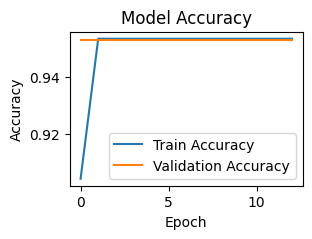

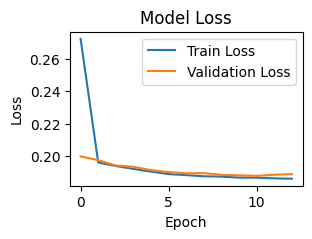

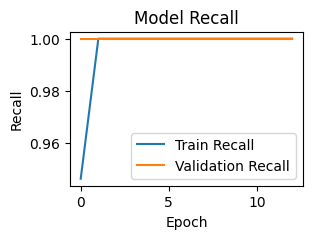

In [10]:
# Plot training and validation accuracy, loss, and recall as three separate plots
plt.figure(figsize=(3, 2))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(3, 2))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

if 'recall' in history.history:  # Only plot if recall is available
    plt.figure(figsize=(3, 2))
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Model Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()

In [11]:
# Load the trained LSTM model
model_path = 'lstm_attribution_model.h5'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file '{model_path}' not found. Please ensure the file exists in the working directory.")
model = load_model(model_path)

channel_to_idx = {ch: i for i, ch in enumerate(channels)}
idx_to_channel = {i: ch for i, ch in enumerate(channels)}
campaign_to_idx = {c: i for i, c in enumerate(campaigns)}
idx_to_campaign = {i: c for i, c in enumerate(campaigns)}

#### Channel Path & Campaign Path Beam Search

In [21]:
# use stochastic sampling for campaign selection, but deterministic for channel selection
import random
def beam_search_start_channel_with_campaign(model, customer_features, start_channel_name, start_campaign_idx, num_channels, num_campaigns, max_touchpoints, beam_width=5, temperature=1.0, campaign_sample_topk=3):
    if isinstance(start_channel_name, int):
        start_idx = start_channel_name
    else:
        start_idx = channel_to_idx[start_channel_name]
    beams = [([start_idx], [start_campaign_idx], 0)]  # (channels, campaigns, log_prob)
    seen_channel_seqs = set() # Track unique channel sequences
    for t in range(1, max_touchpoints):
        candidates = []
        for ch_seq, camp_seq, log_prob in beams:
            for ch in range(num_channels):
                # For each channel, consider all campaigns, but sample campaigns stochastically
                camp_probs = []
                for camp in range(num_campaigns):
                    new_ch_seq = ch_seq + [ch]
                    new_camp_seq = camp_seq + [camp]
                    if max([new_ch_seq.count(x) for x in set(new_ch_seq)]) > 2:
                        continue
                    if max([new_camp_seq.count(x) for x in set(new_camp_seq)]) > 2:
                        continue
                    ch_seq_tuple = tuple(new_ch_seq)
                    if ch_seq_tuple in seen_channel_seqs:
                        continue
                    ch_arr = np.array([new_ch_seq + [0]*(max_touchpoints-len(new_ch_seq))])
                    camp_arr = np.array([new_camp_seq + [0]*(max_touchpoints-len(new_camp_seq))])
                    prob = model.predict([ch_arr, camp_arr, customer_features], verbose=0)[0,0]
                    prob = np.exp(np.log(prob + 1e-8) / temperature)
                    camp_probs.append((camp, new_ch_seq, new_camp_seq, log_prob + np.log(prob + 1e-8)))
                # Sample campaigns for this channel based on their probabilities
                if camp_probs:
                    # Sort by log-prob, take top-k, then sample from them
                    camp_probs.sort(key=lambda x: x[3], reverse=True)
                    topk = camp_probs[:campaign_sample_topk] if len(camp_probs) > campaign_sample_topk else camp_probs
                    # Convert log-probs to probabilities for sampling
                    logprobs = np.array([x[3] for x in topk])
                    probs = np.exp(logprobs - np.max(logprobs))
                    probs = probs / probs.sum()
                    # Sample one or more campaigns (up to beam_width per channel)
                    sampled_idxs = np.random.choice(len(topk), size=min(beam_width, len(topk)), replace=False, p=probs)
                    for idx in sampled_idxs:
                        camp, new_ch_seq, new_camp_seq, new_log_prob = topk[idx]
                        ch_seq_tuple = tuple(new_ch_seq)
                        if ch_seq_tuple in seen_channel_seqs:
                            continue
                        seen_channel_seqs.add(ch_seq_tuple)
                        candidates.append((new_ch_seq, new_camp_seq, new_log_prob))
        # After all channels, keep top beam_width overall
        candidates.sort(key=lambda x: x[2], reverse=True)
        beams = candidates[:beam_width]
    return [((ch, camp), score) for ch, camp, score in beams]

In [26]:
# Title widget for the UI
title_widget = widgets.HTML('<h1 style="text-align:center; margin-bottom: 20px;">Multi-Touch Customer Optimization Tool</h1>')

def update_paths(start_channel, start_campaign, age, income, marital_status, temperature):
    # Encode marital status using the same encoder as in preprocessing
    marital_status_enc = le_marital.transform([marital_status])[0] if hasattr(le_marital, 'classes_') else 1
    customer_features = np.array([[age, income, marital_status_enc]])
    customer_features_scaled = scaler.transform(customer_features)
    if isinstance(start_campaign, int):
        start_campaign_idx = start_campaign
    else:
        start_campaign_idx = campaign_to_idx[start_campaign]
    results = beam_search_start_channel_with_campaign(model, customer_features_scaled, start_channel, start_campaign_idx, num_channels, num_campaigns, max_touchpoints, beam_width=3, temperature=temperature)
    clear_output(wait=True)
    # Print best paths with reduced font size for readability
    html = f'<div style="font-size:12px; font-family:monospace; margin-bottom:10px;">Best paths starting from <b>{start_channel}</b> / <b>{start_campaign}</b> for Age=<b>{age}</b>, Income=<b>{income}</b>, Marital Status=<b>{marital_status}</b>, Temperature=<b>{temperature}</b>:'
    for (ch_seq, camp_seq), score in results:
        html += f'<br>Channels: {[idx_to_channel[i] for i in ch_seq]}, Campaigns: {[idx_to_campaign[i] for i in camp_seq]}, Log-Prob: {score:.4f}'
    html += '</div>'
    display(HTML(html))
    # Side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
    for i, ((ch_seq, camp_seq), score) in enumerate(results):
        ax1.plot(range(len(ch_seq)), ch_seq, marker='o', label=f'Path {i+1} (log-prob={score:.2f})')
        ax2.plot(range(len(camp_seq)), camp_seq, marker='s', label=f'Path {i+1} (log-prob={score:.2f})')
    ax1.set_xticks(range(max_touchpoints))
    ax1.set_yticks(range(num_channels))
    ax1.set_yticklabels([idx_to_channel[i] for i in range(num_channels)])
    ax1.set_ylabel('Channel')
    ax1.set_xlabel('Touchpoint Order')
    ax1.set_title(f'Best Channel Paths Starting from {start_channel}')
    ax1.legend()
    ax2.set_xticks(range(max_touchpoints))
    ax2.set_yticks(range(num_campaigns))
    ax2.set_yticklabels([idx_to_campaign[i] for i in range(num_campaigns)])
    ax2.set_xlabel('Touchpoint Order')
    ax2.set_ylabel('Campaign')
    ax2.set_title('Campaign Paths for Each Beam')
    ax2.legend()
    plt.tight_layout()
    plt.show()

# --- Display the title and dropdowns directly under the title ---
style = {'description_width': 'initial'}
channel_selector = widgets.Dropdown(options=channels, value=channels[0], description='Starting Channel:', style=style)
campaign_selector = widgets.Dropdown(options=campaigns, value=campaigns[0], description='Starting Campaign:', style=style)
marital_status_selector = widgets.Dropdown(options=le_marital.classes_ if hasattr(le_marital, 'classes_') else ['single','married','divorced'], value='married', description='Marital Status:', style=style)
age_slider = widgets.IntSlider(value=45, min=18, max=70, step=1, description='Customer Age:', style=style)
income_slider = widgets.IntSlider(value=70000, min=20000, max=200000, step=1000, description='Customer Income:', style=style)
temperature_slider = widgets.FloatSlider(value=1.0, min=0.1, max=2.0, step=0.1, description='Temperature:', style=style)
ui = widgets.VBox([title_widget, channel_selector, campaign_selector,  marital_status_selector, age_slider, income_slider, temperature_slider])
out = widgets.interactive_output(update_paths, {'start_channel': channel_selector, 'start_campaign': campaign_selector, 'marital_status': marital_status_selector, 'age': age_slider, 'income': income_slider, 'temperature': temperature_slider})
display(ui, out)

Output()